# Amazing ML journey with Stan    
Welcome! Let me show you around on this amazing experience.   
FOR THE LOVE OF GOD DO NOT JUST RUN THE WHOLE THING!    


## 1. Data processing

#### The path    
First, make sure that you have created a .py file containing variable AUDIO_DATA_PATH with the path to the audio data, pointing to AUDIO.

In [1]:
import paths
# Create a .py file containing variable AUDIO_DATA_PATH with the path to the audio data, pointing to AUDIO
AUDIO_DATA_PATH = paths.AUDIO_DATA_PATH
print(AUDIO_DATA_PATH)
# The structure of the data folder should be as follows:

#         ↓   The path should be pointing to this folder
# data/AUDIO/
#           FAKE
#           REAL

data/AUDIO


### Imports

In [2]:
# Imports go brrrrrr
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import wave
import cv2
import matplotlib.pyplot as plt
import sklearn
import scipy.io.wavfile as wav

from keras import layers
from keras import models
from IPython import display
from pydub import AudioSegment

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split


c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Splitting audio    


In [4]:
# Splitting the data into 10 second fragments and saving them to the AUDIO folder

def split_audio(input_folder, output_folder, duration=10):

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".mp3") or file.endswith(".wav"):
                input_path = os.path.join(root, file)
                print(input_path)
                audio = AudioSegment.from_file(input_path)

                for i, chunk in enumerate(audio[::duration * 1000]): # duration 10 seconds
                    chunk_name = f"{os.path.splitext(file)[0]}_{i}.wav"
                    output_path = os.path.join(output_folder, chunk_name)
                    chunk.export(output_path, format="wav")

input_folder = AUDIO_DATA_PATH
output_folder_real = os.path.join(AUDIO_DATA_PATH, "NEW_REAL")
output_folder_fake = os.path.join(AUDIO_DATA_PATH, "NEW_FAKE")

split_audio(os.path.join(input_folder, "REAL"), output_folder_real)
split_audio(os.path.join(input_folder, "FAKE"), output_folder_fake)


data/AUDIO\REAL\biden-original.wav
data/AUDIO\REAL\biden2.wav
data/AUDIO\REAL\biden3.wav
data/AUDIO\REAL\biden4.wav
data/AUDIO\REAL\linus-original.wav
data/AUDIO\REAL\linus2.wav
data/AUDIO\REAL\linus3.wav
data/AUDIO\REAL\margot-original.wav
data/AUDIO\REAL\margot.wav
data/AUDIO\REAL\musk-original.wav
data/AUDIO\REAL\musk.wav
data/AUDIO\REAL\musk2.wav
data/AUDIO\REAL\obama-original.wav
data/AUDIO\REAL\obama2.wav
data/AUDIO\REAL\ryan-original.wav
data/AUDIO\REAL\ryan.wav
data/AUDIO\REAL\taylor-original.wav
data/AUDIO\REAL\taylor.wav
data/AUDIO\REAL\trump-original.wav
data/AUDIO\REAL\trump.wav
data/AUDIO\REAL\trump2.wav
data/AUDIO\REAL\trump33.wav
data/AUDIO\FAKE\biden-to-linus.wav
data/AUDIO\FAKE\biden-to-margot.wav
data/AUDIO\FAKE\biden-to-musk.wav
data/AUDIO\FAKE\biden-to-Obama.wav
data/AUDIO\FAKE\biden-to-ryan.wav
data/AUDIO\FAKE\biden-to-taylor.wav
data/AUDIO\FAKE\biden-to-Trump.wav
data/AUDIO\FAKE\linus-to-biden.wav
data/AUDIO\FAKE\linus-to-margot.wav
data/AUDIO\FAKE\linus-to-musk.w

### Saving images  
Now it's time to save all slices of audio as spectograms    
(This might take a while, for me it was 12 minutes)

In [3]:
path = AUDIO_DATA_PATH

fake_img = "FAKE_IMG"
real_img = "REAL_IMG"

# Create folders if they don't exist
if not os.path.exists(fake_img):
    os.makedirs(fake_img)
if not os.path.exists(real_img):
    os.makedirs(real_img)

for subfolder in os.listdir(path):
    
    if subfolder == "NEW_FAKE":
        output = fake_img
    elif subfolder == "NEW_REAL":
        output = real_img
    else:
        continue

    for file in os.listdir(os.path.join(path, subfolder)):
        if file.endswith(".wav"):
            sample_rate, data = wav.read(os.path.join(path, subfolder, file))
            data = np.mean(data, axis=1) # mono channel is a mean of both channels
            plt.specgram(data, Fs=sample_rate)
            plt.savefig(os.path.join(output, file[:-4] + ".png"))
            plt.clf()


C:\Users\wasil\AppData\Local\Temp\ipykernel_1964\1412102039.py:25: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=144).
  plt.specgram(data, Fs=sample_rate)
c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\matplotlib\axes\_axes.py:7944: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 640x480 with 0 Axes>

## 2. Model training

### Splitting data into train, test, and validation sets

In [3]:
image_size = (128, 128)
validation_split = 0.3
seed_train_validation = 1
shuffle_value = True

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/IMAGES',
    image_size=image_size,
    validation_split=validation_split,
    subset="training",
    seed=seed_train_validation,
    color_mode='grayscale', # normal matrix multiplication is hard enough
    shuffle=shuffle_value
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/IMAGES',
    image_size=image_size,
    validation_split=validation_split,
    subset="validation",
    seed=seed_train_validation,
    color_mode='grayscale',
    shuffle=shuffle_value
)

# number of batches in the validation set
val_batches = tf.data.experimental.cardinality(val_ds)

# split validation into test and validation sets
test_ds = val_ds.take((2 * val_batches) // 3)
val_ds = val_ds.skip((2 * val_batches) // 3)



Found 4556 files belonging to 2 classes.
Using 3190 files for training.
Found 4556 files belonging to 2 classes.
Using 1366 files for validation.


## Construct the model



In [4]:


model = models.Sequential([
    # CNN

    # 32 filters with 3x3 kernels
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1)),
    # 2x2 pool size so we downsample by 2
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Transform the output of the CNN (matrix) to a vector
    layers.Flatten(),
    
    # DENSEEEE
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # We don't really need that but it might help, idk

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # We don't really need that but it might help, idk

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2), 

    layers.Dropout(0.32), 
    layers.Dropout(0.2), 

    layers.Dense(1, activation='sigmoid')  # Sigmoid so we can set a threshold
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001) # We can set the learning rate here
model.compile(optimizer=optimizer, # We can try different things here
              loss='binary_crossentropy', # Here also we can try something different
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

### Train the model

In [6]:
# train_ds, val_ds, test_ds 

epochs = 10
batch_size = 32

# Train the shit out of it
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model on the tes  t set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")



Epoch 1/10


100/100 [==============================] - 30s 302ms/step - loss: 0.5390 - accuracy: 0.7254 - val_loss: 0.3506 - val_accuracy: 0.9277
Epoch 2/10
100/100 [==============================] - 30s 294ms/step - loss: 0.4262 - accuracy: 0.8063 - val_loss: 0.2020 - val_accuracy: 0.9553
Epoch 3/10
100/100 [==============================] - 30s 293ms/step - loss: 0.3338 - accuracy: 0.8680 - val_loss: 0.1865 - val_accuracy: 0.9596
Epoch 4/10
100/100 [==============================] - 30s 300ms/step - loss: 0.2849 - accuracy: 0.8978 - val_loss: 0.1584 - val_accuracy: 0.9532
Epoch 5/10
100/100 [==============================] - 31s 310ms/step - loss: 0.2376 - accuracy: 0.9163 - val_loss: 0.1421 - val_accuracy: 0.9617
Epoch 6/10
100/100 [==============================] - 31s 309ms/step - loss: 0.2103 - accuracy: 0.9232 - val_loss: 0.1181 - val_accuracy: 0.9723
Epoch 7/10
100/100 [==============================] - 31s 309ms/step - loss: 0.2002 - accuracy: 0.9251 - val_loss: 0.1174 - val_accuracy: 0.9

In [5]:
import visualkeras
visualkeras.layered_view(model, legend=True).save('model_visualization.png')

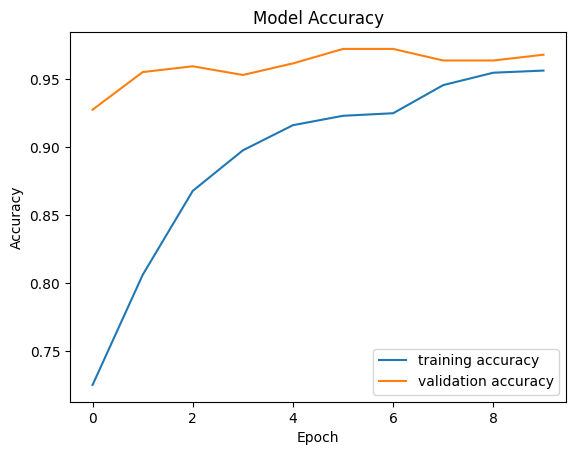

In [8]:

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

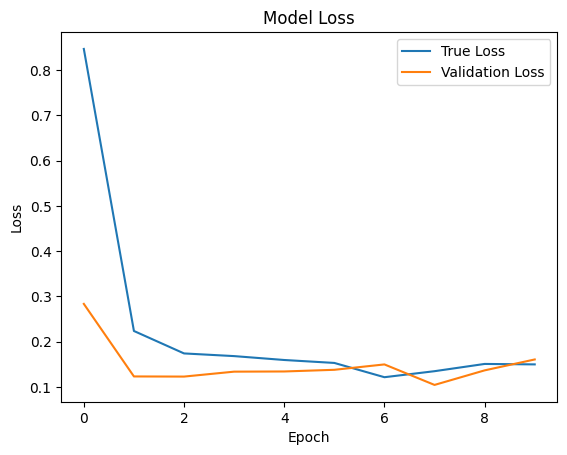

In [12]:
plt.plot(history.history['loss'], label='True Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predicting

In [14]:
# Fake

test_image_path = 'data/IMAGES/FAKE_IMG/biden-to-margot_1.png'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE) # again, grayscale
test_image = cv2.resize(test_image, (128, 128))
test_image = np.expand_dims(test_image, axis=0) # batch dimension


prediction = model.predict(test_image)

if prediction[0][0] >= 0.5: # the sensitivity can be changed
    print("The audio is predicted as REAL.")
else:
    print("The audio is predicted as FAKE.")


1/1 [==============================] - 0s 23ms/step
The audio is predicted as FAKE.


In [15]:
# Real

test_image_path = 'data/IMAGES/REAL_IMG/biden-original_0.png'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE) # again, grayscale
test_image = cv2.resize(test_image, (128, 128))
test_image = np.expand_dims(test_image, axis=0) # batch dimension


prediction = model.predict(test_image)

if prediction[0][0] >= 0.5: # the sensitivity can be changed but I don't see why
    print("The audio is predicted as REAL.")
else:
    print("The audio is predicted as FAKE.")


1/1 [==============================] - 0s 57ms/step
The audio is predicted as REAL.
